In [13]:
import lifelines
from lifelines import CoxPHFitter, NelsonAalenFitter, KaplanMeierFitter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## dataset from lifelines

In [6]:
df = lifelines.datasets.load_kidney_transplant()

In [7]:
df.head()

,time,death,age,black_male,white_male,black_female
0,1,0,46,0,1,0
1,5,0,51,0,1,0
2,7,1,55,0,1,0
3,9,0,57,0,1,0
4,13,0,45,0,1,0


In [8]:
df['death'].value_counts()

0    723
1    140
Name: death, dtype: int64

<Axes: xlabel='timeline'>

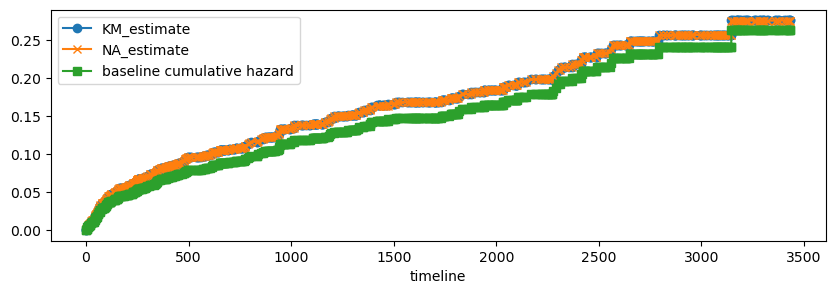

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10,3))

km = KaplanMeierFitter()
km.fit(df['time'], df['death'])
(1 - km.survival_function_).plot(marker='o', ax=ax)

na = NelsonAalenFitter()
na.fit(df['time'], df['death'])
(1 - np.exp(-na.cumulative_hazard_)).plot(marker='x', ax=ax)

cox = CoxPHFitter()
cox.fit(df, 'time', 'death')
(1 - np.exp(-cox._model.baseline_cumulative_hazard_)).plot(marker='s', ax=ax)

## Make the data imbalanced

Make a large portion of events non-events, make the corresponding time to the max (so basically these population never experienced an event till the every end of observation window)

In [24]:
df2 = df.copy(deep=True)
df2['rand'] = np.random.rand(df2.shape[0])

df2['death'] = np.where(df2['rand'] < 0.99, 0, 1)
df2['time'] = np.where(df2['rand'] < 0.99, 3500, df2['time'])

df2.head()

,time,death,age,black_male,white_male,black_female,rand
0,3500,0,46,0,1,0,0.559592
1,3500,0,51,0,1,0,0.690217
2,3500,0,55,0,1,0,0.836174
3,3500,0,57,0,1,0,0.094149
4,3500,0,45,0,1,0,0.242824


In [25]:
df2['death'].value_counts()

0    856
1      7
Name: death, dtype: int64

/Users/kai/anaconda3/lib/python3.10/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column black_female have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['death'].astype(bool)
>>> print(df.loc[events, 'black_female'].var())
>>> print(df.loc[~events, 'black_female'].var())

A very low variance means that the column black_female completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/kai/anaconda3/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#p

<Axes: xlabel='timeline'>

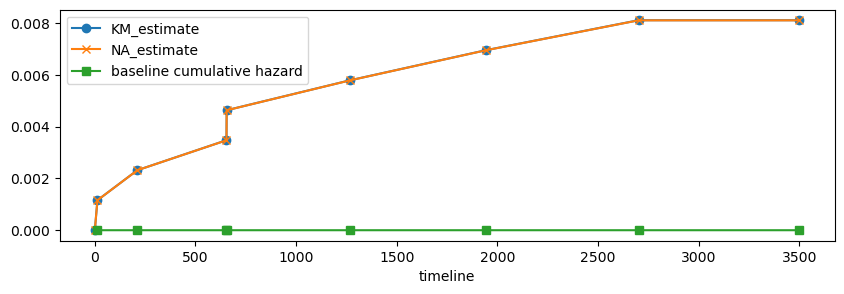

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10,3))

km = KaplanMeierFitter()
km.fit(df2['time'], df2['death'])
(1 - km.survival_function_).plot(marker='o', ax=ax)

na = NelsonAalenFitter()
na.fit(df2['time'], df2['death'])
(1 - np.exp(-na.cumulative_hazard_)).plot(marker='x', ax=ax)

cox = CoxPHFitter()
cox.fit(df2, 'time', 'death')
(1 - np.exp(-cox._model.baseline_cumulative_hazard_)).plot(marker='s', ax=ax)

## Self-Create a Synthetic Dataset

For each individual, draw a lottry X ~ rand(0, 1)
* If X < 0.99, no event till the very end t = 100 (censored)
* If X > 0.99, each period, hazard happens with probability p 

In [56]:
N = 1000 # obs
T = 100 # time
p = 0.02 # threshold to trigger the event

rand2 = np.random.rand(N, T)
event2 = (rand2 < p)
max_event1, first_time_event1 = np.max(event2, axis = 1), np.argmax(event2, axis = 1)


In [57]:

df = pd.DataFrame(index = range(N))
df['rand'] = np.random.rand(N)
df['E'] = np.where((df['rand'] < 0.99) | (max_event1 == False), 0, 1)
df['T'] = (df['rand'] < 0.99) * T + (df['rand'] >= 0.99) * (max_event1 == True) * first_time_event1 + (df['rand'] >= 0.99) * (max_event1 == False) * T 

df.head(200)

,rand,E,T
0,0.812326,0,100
1,0.090254,0,100
2,0.960789,0,100
3,0.134535,0,100
4,0.050073,0,100
...,...,...,...
195,0.610844,0,100
196,0.240486,0,100
197,0.820540,0,100
198,0.095075,0,100


/Users/kai/anaconda3/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


<Axes: xlabel='timeline'>

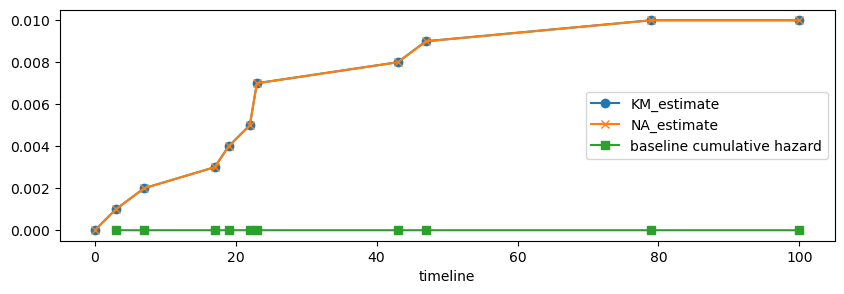

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(10,3))

km = KaplanMeierFitter()
km.fit(df['T'], df['E'])
(1 - km.survival_function_).plot(marker='o', ax=ax)

na = NelsonAalenFitter()
na.fit(df['T'], df['E'])
(1 - np.exp(-na.cumulative_hazard_)).plot(marker='x', ax=ax)

cox = CoxPHFitter()
cox.fit(df, 'T', 'E')
(1 - np.exp(-cox._model.baseline_cumulative_hazard_)).plot(marker='s', ax=ax)